## Task 2: Bayesian Change Point Detection

**Objective:** Use PyMC to statistically identify the date when a significant shift in Brent oil prices occurred and quantify the change.


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
C:\Users\YODAHE\AppData\Local\Temp\ipykernel_21100\2407681600.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


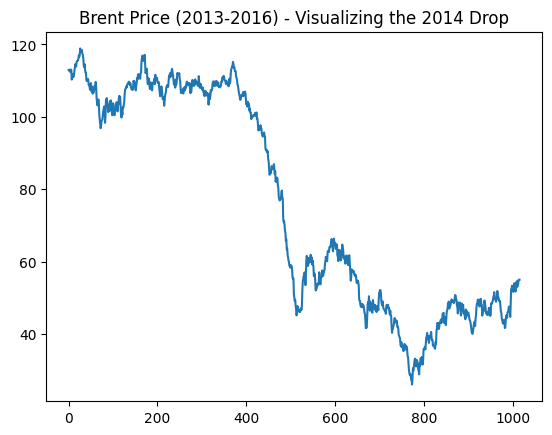

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Load data
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

# Select a specific window for the model (e.g., The 2014 Price Drop)
# This makes it easier to see the change point in action
data_subset = df[(df['Date'] >= '2013-01-01') & (df['Date'] <= '2016-12-31')].copy()
data_subset.reset_index(drop=True, inplace=True)

# Plot the subset to visualize what the model sees
plt.plot(data_subset['Price'])
plt.title("Brent Price (2013-2016) - Visualizing the 2014 Drop")
plt.show()

# Get the price as a numpy array
prices = data_subset['Price'].values
n_data = len(prices)

### Building the PyMC Model
We define:
*   **$\tau$ (Tau):** The day the change happens (discrete uniform prior).
*   **$\mu_1$:** The average price before the change.
*   **$\mu_2$:** The average price after the change.
*   **Likelihood:** We assume the prices follow a Normal distribution.


In [2]:
with pm.Model() as change_point_model:
    # Prior for the switchpoint (it could happen at any day in the dataset)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_data - 1)
    
    # Priors for the mean prices
    mu_1 = pm.Normal("mu_1", mu=prices.mean(), sigma=prices.std())
    mu_2 = pm.Normal("mu_2", mu=prices.mean(), sigma=prices.std())
    
    # Standard deviation of the price (can be shared or separate)
    sigma = pm.Exponential("sigma", lam=1.0)
    
    # Logic: If current index < tau, use mu_1, else use mu_2
    idx = np.arange(n_data)
    mu_ = pm.math.switch(tau >= idx, mu_1, mu_2)
    
    # Likelihood (how the model sees the data)
    observation = pm.Normal("obs", mu=mu_, sigma=sigma, observed=prices)

    # Inference: Running the MCMC sampler
    # This might take a minute
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\YODAHE\Desktop\10Academy-Week10\brent-oil-price-analysis\venv\Lib\site-packages\rich\live.py:260: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1345 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Analyzing the Results
We look at the Posterior Distribution. This shows us the most likely date for the switch and the price levels before and after.


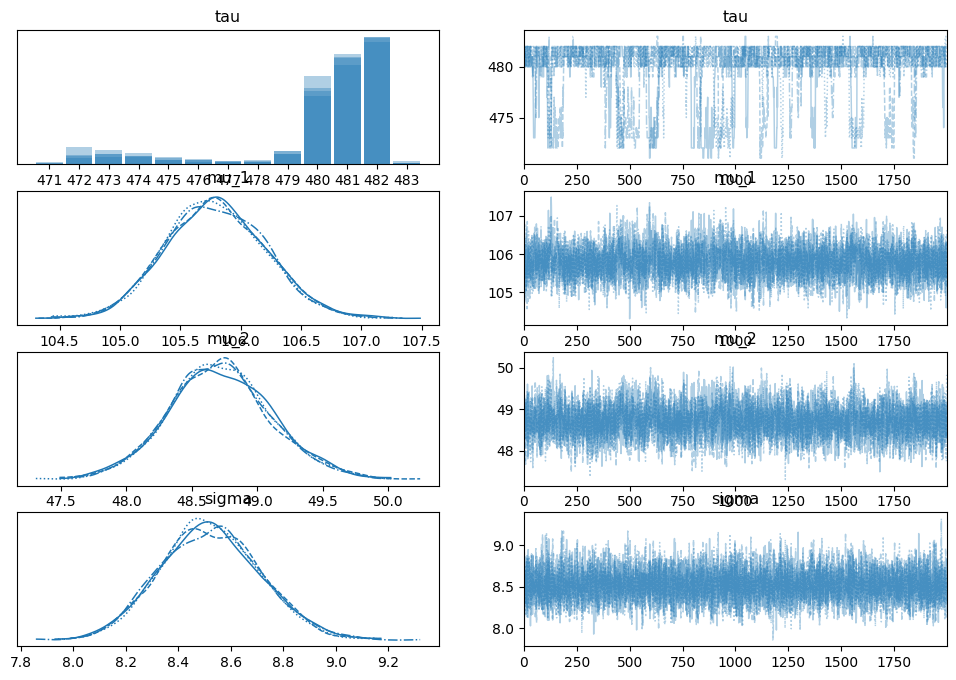

         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1  105.794  0.416  105.002  106.552      0.010    0.005    1658.0   
mu_2   48.717  0.391   47.988   49.488      0.010    0.005    1688.0   
tau   480.197  2.582  473.000  482.000      0.183    0.207     344.0   

      ess_tail  r_hat  
mu_1    2126.0   1.00  
mu_2    2241.0   1.00  
tau      273.0   1.01  

The model detected a significant change point on: 2014-11-25 00:00:00


In [3]:
# Trace plot: Check if the model converged (curves should be smooth)
az.plot_trace(trace)
plt.show()

# Summary statistics for mu_1, mu_2, and tau
print(az.summary(trace, var_names=["mu_1", "mu_2", "tau"]))

# Map Tau back to a Date
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.median(tau_samples))
change_date = data_subset.iloc[most_likely_tau]['Date']

print(f"\nThe model detected a significant change point on: {change_date}")

### Associating with Events
Compare the detected date (`change_date`) with your `key_events.csv`.  
For example, if the date is near **Nov 27, 2014**, it corresponds to the **OPEC meeting** where they decided not to cut production.


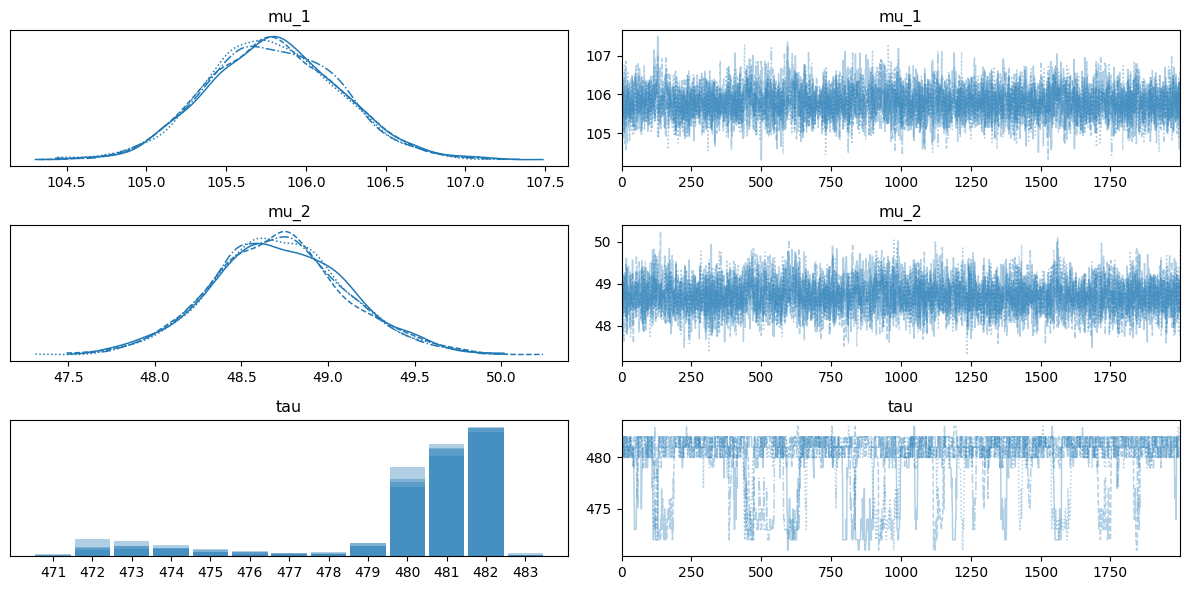

         mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1  105.794  0.416  105.002  106.552      0.010    0.005    1658.0   
mu_2   48.717  0.391   47.988   49.488      0.010    0.005    1688.0   
tau   480.197  2.582  473.000  482.000      0.183    0.207     344.0   

      ess_tail  r_hat  
mu_1    2126.0   1.00  
mu_2    2241.0   1.00  
tau      273.0   1.01  


In [4]:
# 1. Plot the Trace
az.plot_trace(trace, var_names=["mu_1", "mu_2", "tau"])
plt.tight_layout()
plt.show()

# 2. Get the specific statistics
summary = az.summary(trace, var_names=["mu_1", "mu_2", "tau"])
print(summary)

In [5]:
# Map the 'tau' index back to a real date
tau_mean = int(summary.loc['tau', 'mean'])
detected_date = data_subset.iloc[tau_mean]['Date']

# Get the price means
price_before = summary.loc['mu_1', 'mean']
price_after = summary.loc['mu_2', 'mean']
percent_change = ((price_after - price_before) / price_before) * 100

print(f"--- INSIGHTS ---")
print(f"Detected Change Point Date: {detected_date.strftime('%Y-%m-%d')}")
print(f"Price Before: ${price_before:.2f}")
print(f"Price After: ${price_after:.2f}")
print(f"Impact: {percent_change:.2f}% change in average price.")

--- INSIGHTS ---
Detected Change Point Date: 2014-11-24
Price Before: $105.79
Price After: $48.72
Impact: -53.95% change in average price.


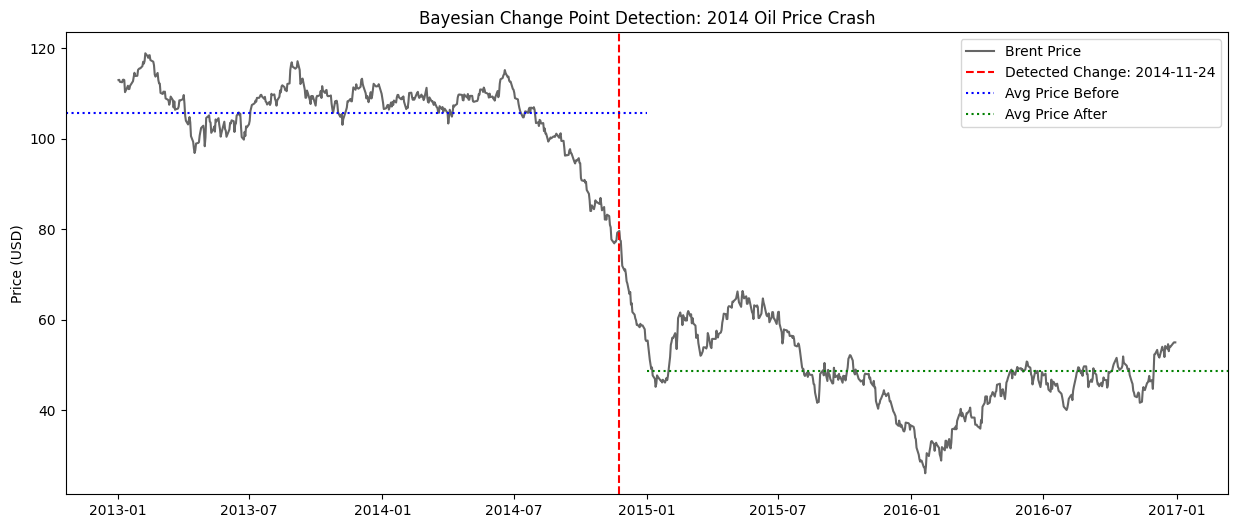

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(data_subset['Date'], data_subset['Price'], label='Brent Price', color='black', alpha=0.6)
plt.axvline(detected_date, color='red', linestyle='--', label=f'Detected Change: {detected_date.strftime("%Y-%m-%d")}')

# Add shaded areas for mu_1 and mu_2 levels
plt.axhline(price_before, xmin=0, xmax=0.5, color='blue', linestyle=':', label='Avg Price Before')
plt.axhline(price_after, xmin=0.5, xmax=1, color='green', linestyle=':', label='Avg Price After')

plt.title("Bayesian Change Point Detection: 2014 Oil Price Crash")
plt.legend()
plt.ylabel("Price (USD)")
plt.show()